In [14]:
#import library
import tensorflow as tf
import numpy as np
from mnist import loader
import random
import pdb 
import matplotlib.pyplot as plt
import time

# Build NN model

You can picture our softmax regression as looking something like the following, although with a lot more xs. For each output, we compute a weighted sum of the xs, add a bias, and then apply softmax.

![](imgs/simple_model.png)

We can "vectorize" this procedure, turning it into a matrix multiplication and vector addition. This is helpful for computational efficiency. (It's also a useful way to think.)

![](imgs/vetector.png)
    
  ## cross-entropy

![](imgs/cross_entropy.png)

In [78]:
def NNmodel():
    mnist_dim = 28
    hidden_dim = 300
    n_class = 10

    # create Variables
    weights= {  'w1' : tf.Variable(tf.truncated_normal([mnist_dim*mnist_dim, hidden_dim], mean = 0, stddev = 0.01), name='w1'),
                'w2' : tf.Variable(tf.truncated_normal([hidden_dim, n_class], mean = 0, stddev = 0.01), name='w2')}

    biases = {  'b1' : tf.Variable(tf.truncated_normal([hidden_dim]), name='b1'),
                'b2' : tf.Variable(tf.truncated_normal([n_class]), name='b2')}


    x = tf.placeholder(tf.float32, shape=[None, mnist_dim*mnist_dim], name='x')
    y = tf.placeholder(tf.int32, name='y')    # default shape=None
    dropout = tf.placeholder(tf.float32)  #dropout ratio

    h1 = tf.matmul(x, weights['w1'])+biases['b1']
    h1 = tf.nn.relu(h1)
    h1 = tf.nn.dropout(h1, keep_prob = 1-dropout)
    pred = tf.matmul(h1, weights['w2'])+biases['b2']
    probs = tf.nn.softmax(pred)
    
    log_probs = tf.log(probs + 1e-8)

    one_hot_y = tf.one_hot(y, n_class, on_value=1, off_value=0, axis=-1)
    cross_entropy_loss = - tf.mul(tf.cast(one_hot_y, tf.float32),log_probs)
    loss = tf.reduce_sum(cross_entropy_loss)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(one_hot_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    return x, y, dropout, probs, loss, accuracy


# Paramaters

### one  epoch：所有的訓練樣本完成一次Forword運算以及一次BP運算, 即看過所有資料一遍

### batch size：一次Forword運算以及BP運算中所需要的訓練樣本數目，其實深度學習每一次參數的更新所需要損失函數並不是由一個{data：label}獲得的，而是由一組數據加權得到的，這一組數據的數量就是 batch size 。batch size越大，所需的內存就越大。

### iterations（迭代）：每一次迭代都是一次權重更新，每一次權重更新需要batch size個數據進行Forward運算, 得到損失函數(loss)，再BP 算法更新參數。

### 公式:  訓練样本的数量/batch size = numbers of iterations => one epoch

In [79]:
def paramaters(ims, ims_test):
    lr = 0.001
    batch_size = 20
    n_epoch = 5
    iter_per_epoch = int(len(ims)/batch_size)
    iter_per_epoch_test = int(len(ims_test)/batch_size)
    return lr, batch_size, n_epoch, iter_per_epoch, iter_per_epoch_test

# Load data

MNIST is a simple computer vision dataset. It consists of images of handwritten digits like these:

![](imgs/mnist_data.png)

Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:

![](imgs/mnist_pixel.png)

The result is that mnist.train.images is a tensor (an n-dimensional array) with a shape of [55000, 784]. The first dimension is an index into the list of images and the second dimension is the index for each pixel in each image. Each entry in the tensor is a pixel intensity between 0 and 1, for a particular pixel in a particular image.

![](imgs/mnist_train.png)

For the purposes of this tutorial, we're going to want our labels as "one-hot vectors". A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the nth digit will be represented as a vector which is 1 in the nth dimension. For example, 3 would be [0,0,0,1,0,0,0,0,0,0]. Consequently, mnist.train.labels is a [55000, 10] array of floats.

![](imgs/mnist_label.png)

In [80]:
def load_data():   
    data_path = 'data'
    data_loader = loader.MNIST(data_path)
    ims, labels = data_loader.load_training()
    ims_test, labels_test = data_loader.load_testing()

    #ims= np.float32(ims) + 128
    ims = ims/255.0
    ims_test = ims_test/255.0

    im_mean = np.mean(ims,axis=0)
    
    return ims, im_mean, labels, ims_test, labels_test

In [90]:

def train():
    total_time = 0.0
    ims, im_mean, labels, ims_test, labels_test = load_data()
    lr, batch_size, n_epoch, iter_per_epoch, iter_per_epoch_test = paramaters(ims, ims_test)
    #pdb.set_trace()

    loss_train = []
    loss_test = []
    Acc_train = []
    Acc_test = []

    x, y, dropout, tf_probs, tf_loss, accuracy = NNmodel()
    tf_loss = tf_loss/batch_size

    #optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(tf_loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = lr).minimize(tf_loss)
    # create session
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    order_list_train = range(len(ims))
    order_list_test = range(len(ims_test))
    #pdb.set_trace()
    for epoch in xrange(n_epoch):
        start = time.time()
        random.shuffle(order_list_train)
        random.shuffle(order_list_test)
        print "Epoch %d"%(epoch)
        cost_train = 0 
        cost_test = 0 
        A_train = 0 
        A_test = 0 
        for idx in xrange(iter_per_epoch):
            batch_xs = ims[order_list_train[idx*batch_size:(idx+1)*batch_size]] - im_mean
            batch_ys = labels[order_list_train[idx*batch_size:(idx+1)*batch_size]]
            P, L, A, _= sess.run([tf_probs, tf_loss,accuracy,optimizer],feed_dict={x:batch_xs, y:batch_ys,dropout:0.8})
            cost_train += L
            A_train += A
        for idx in xrange(iter_per_epoch_test):
            batch_xs_test = ims_test[order_list_test[idx*batch_size:(idx+1)*batch_size]] - im_mean
            batch_ys_test = labels_test[order_list_test[idx*batch_size:(idx+1)*batch_size]]
            P, L, A = sess.run([tf_probs, tf_loss, accuracy],feed_dict={x:batch_xs_test, y:batch_ys_test, dropout:0.0})  
            cost_test += L
            A_test += A
        if (epoch+1)%1==0:
            #saver.save(sess, 'models/NN'+str(epoch+1), global_step = epoch+1)
            loss_train.append(cost_train/iter_per_epoch)
            Acc_train.append(A_train/iter_per_epoch)
            loss_test.append(cost_test/iter_per_epoch_test)
            Acc_test.append(A_test/iter_per_epoch_test)
        print "Training_loss= %f  Training_Accuracy=%f  \t Testing_loss= %f  Testing_Accuracy= %f" \
        %(cost_train/iter_per_epoch,A_train/iter_per_epoch, cost_test/iter_per_epoch_test,A_test/iter_per_epoch_test)
        total = (time.time() - start)/60
        total_time += total
        #print total
    print "Average time is %f"%(total_time/n_epoch)
    plt.figure(1)
    plt.title('Loss. Blue-training, red-testing')
    plt.xlabel('Epochs')
    plt.plot(loss_train, 'b', loss_test, 'r')
    plt.figure(2)
    plt.title('Accuracy. Blue-training, Red-testing')
    plt.plot(Acc_train, 'b', Acc_test, 'r')
    plt.title('Accuracy. Blue-training, Red-testing')
    plt.show()
    #plt.savefig('result.png')


In [91]:
def test():
    data_path = 'data'
    data_loader = loader.MNIST(data_path)
    ims, labels = data_loader.load_testing()
    ims = ims/255.0
    im_mean = np.mean(ims,axis=0)
    #pdb.set_trace()
    batch_size = 50
    n_epoch = 1
    iter_per_epoch = len(ims)/batch_size

    x, y, dropout, tf_probs, tf_loss, accuracy = NNmodel()
    tf_loss = tf_loss/batch_size

    #optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(tf_loss)

    # create session
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    saver.restore(sess,'models/NN50-50')
    order_list = range(len(ims))
    correct = 0
    total = 0
    for epoch in xrange(n_epoch):
        random.shuffle(order_list)
        print "Epoch %d"%(epoch)

        for idx in xrange(iter_per_epoch):
            batch_xs = ims[order_list[idx*batch_size:(idx+1)*batch_size]] - im_mean
            batch_ys = labels[order_list[idx*batch_size:(idx+1)*batch_size]]
            #batch_ys = one_hot(batch_ys,10)
            #batch_xs, batch_ys = MNIST.test.next_batch(batch_size)
            P, L = sess.run([tf_probs, tf_loss], feed_dict={x:batch_xs, y:batch_ys, dropout:0.0})
            #pdb.set_trace()

            #if np.argmax(P) == np.argmax(batch_ys[0]):
            #    correct += 1
            #correct += np.sum(np.argmax(P,axis=1) == np.argmax(batch_ys, axis=1))
            correct += np.sum(np.argmax(P, axis=1) == batch_ys)
            total += len(P)
        print "accuary= %f (%d/%d)"%(float(correct)/total, correct, total)




Epoch 0
Training_loss= 2.284811  Training_Accuracy=0.145450  	 Testing_loss= 2.169154  Testing_Accuracy= 0.444200
Epoch 1
Training_loss= 2.031496  Training_Accuracy=0.302183  	 Testing_loss= 1.715175  Testing_Accuracy= 0.670600
Epoch 2
Training_loss= 1.621248  Training_Accuracy=0.463233  	 Testing_loss= 1.256501  Testing_Accuracy= 0.743100
Epoch 3
Training_loss= 1.330924  Training_Accuracy=0.559750  	 Testing_loss= 0.980329  Testing_Accuracy= 0.784800
Epoch 4
Training_loss= 1.152085  Training_Accuracy=0.619567  	 Testing_loss= 0.812634  Testing_Accuracy= 0.815800
Average time is 0.110750


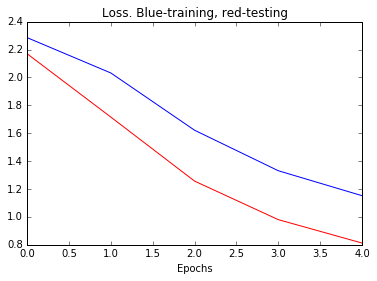

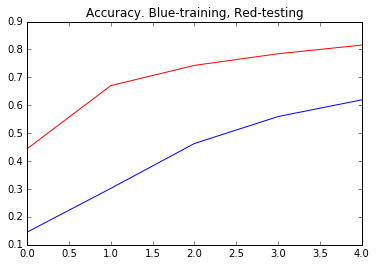

In [92]:
if __name__ == '__main__':
    train()
    #test()

# Compare different batch size (lr = 0.001, hidden dimension = 300)

## batch size = 1


![](imgs/batch_size1.png)

## batch size = 20


![](imgs/batch_size20.png)

## batch size = 200


![](imgs/batch_size200.png)

# Compare different learning rate (batch size = 20, hidden dimension = 300)

## learning rate = 0.01

![](imgs/lr001.png)

## learning rate = 0.001

![](imgs/lr0001.png)

## learning rate = 0.0001

![](imgs/lr00001.png)


# Compare different hidden dimension (lr = 0.001, batch size = 20)

## dimension = 

![](imgs/hidd50.png)

## dimension = 

![](imgs/hidd150.png)

## dimension = 

![](imgs/hidd300.png)


# Compare different dropout rate (lr = 0.001batch size = 20, hidden dimension = 300)

## ropout rate = 0

![](imgs/d0.png)

## ropout rate = 0.5

![](imgs/d05.png)

## ropout rate = 0.8

![](imgs/d08.png)
